### Declarações

In [1]:
using WAV
using Plots
using LinearAlgebra

In [2]:
function senoidal(x, freq, intensidade)
    return sin(2pi * freq * x) * intensidade
end

function cosseno(x, freq, intensidade)
    return cos(2pi * freq * x) * intensidade
end

function ruido(x, intensidade)
    return randn() * intensidade
end

ruido (generic function with 1 method)

In [3]:
function fatora_posto(matriz, posto)
    covariancia = matriz * matriz'
    dim = size(covariancia)[1]
    auto_valores, auto_vetores = eigen(covariancia)
    
    v = auto_vetores[:, dim]
    for i in 1:(posto - 1)
        v = hcat(v, auto_vetores[:, dim - i])
    end
    c = v' * matriz

    return v, c
end

fatora_posto (generic function with 1 method)

In [4]:
fs = 44.1e3                  # Frequencia de amostragem do áudio
t = 0.0:1/fs:prevfloat(5.0)  # Pontos de amostragem em 5 segundos

janela_amostral = 147        # Quantas amostras cada gráfico vai mostrar (Também vai ser quantas amostras tem em cada coluna da matriz)

147

### Exemplo 1: Mostrando a teoria

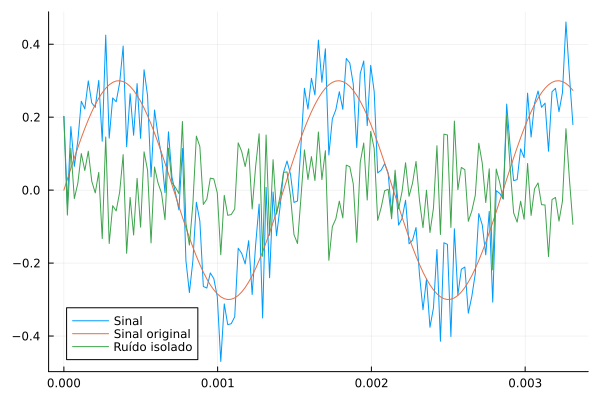

In [5]:
onda_senoidal = senoidal.(t, 0.7e3, 0.3) # Sinal enviado originalmente
senoidal_ruidoso = onda_senoidal + ruido.(t, 0.1) # Sinal recebido após passar por canal ruidoso

ruido_isolado = senoidal_ruidoso - onda_senoidal

wavplay(senoidal_ruidoso, fs)

funcoes = [senoidal_ruidoso onda_senoidal ruido_isolado]
legendas = ["Sinal" "Sinal original" "Ruído isolado"]

dir_s1 = "graficos/senoidal_teste_1/"
t_plot = t[1:janela_amostral]
funcoes_plot = funcoes[1:janela_amostral,:]

mkpath(dir_s1)
savefig(plot(t_plot, funcoes_plot[:, 1], label="Sinal ruidoso", lc=:green, ylims=(-0.5, 0.5)), string(dir_s1, "ruidoso.png"))
savefig(plot(t_plot, funcoes_plot[:, 2], label="Sinal original", lc=:blue, ylims=(-0.5, 0.5)), string(dir_s1, "original.png"))
savefig(plot(t_plot, funcoes_plot[:, 3], label="Ruído isolado", lc=:red, ylims=(-0.5, 0.5)), string(dir_s1, "ruido.png"))

plot(t_plot, funcoes_plot, label=legendas)

Quadrado da norma da matriz de trechos: 12118.483753879316
Soma dos dois maiores autovalores: 9946.610208895305
Soma de todos os outros autovalores: 2171.8735449839887


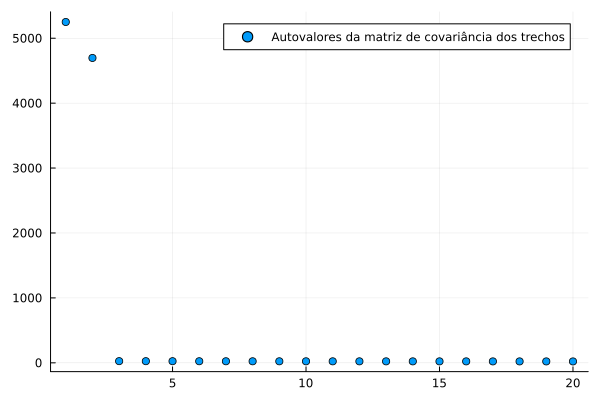

In [6]:
# Construindo uma matriz em que cada coluna é um trecho do áudio
amostras = reshape(senoidal_ruidoso, (janela_amostral, :))

covariancia = amostras * amostras'
auto_valores, auto_vetores = eigen(covariancia)
autoval = sort(auto_valores, by=abs, rev=true)

println("Quadrado da norma da matriz de trechos: ", norm(amostras)^2)
println("Soma dos dois maiores autovalores: ", sum(abs, autoval[1:2]))
println("Soma de todos os outros autovalores: ", sum(abs, autoval[3:end]))

fig = scatter(autoval[1: 20], label="Autovalores da matriz de covariância dos trechos")
savefig(fig, string(dir_s1, "autovalores_covariancia.png"))
fig

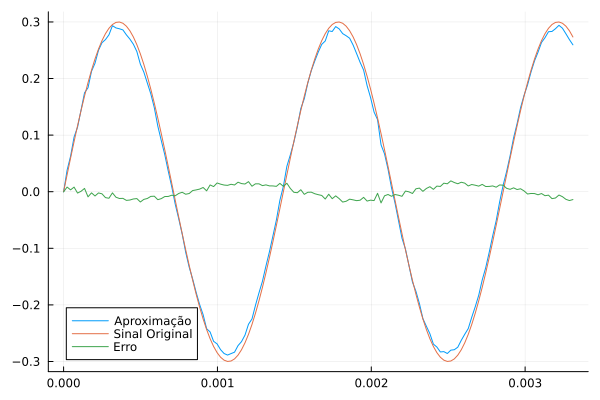

In [7]:
# Aproxima a matriz de trechos
B, C = fatora_posto(amostras, 2)

# Transforma a matriz de trechos encontrada de volta para um vetor coluna (faixa de áudio única)
aprox = reshape(B * C, (:, 1))

erro = aprox - onda_senoidal

funcoes = [aprox onda_senoidal erro]
wavplay(aprox, fs)

funcoes_plot = funcoes[1:janela_amostral, :]

fig_aprox = plot(t_plot, funcoes_plot[:, 1], label="Aproximação obtida", ylims=(-0.5, 0.5))
fig_err = plot(t_plot, funcoes_plot[:, 3], label="Erro isolado", ylims=(-0.5, 0.5))
savefig(fig_aprox, string(dir_s1, "aprox_obtida.png"))
savefig(fig_err, string(dir_s1, "erro_isolado_aprox.png"))

plot(t_plot, funcoes_plot, label=["Aproximação" "Sinal Original" "Erro"])

In [8]:
function aproxima_sinal(audio, posto)
    amostras = reshape(audio, (janela_amostral, :))

    B, C = fatora_posto(amostras, posto)
    return reshape(B * C, (:, 1))
end

function mostra_autovalores_covariancia(sinal)
    matriz = reshape(sinal, (janela_amostral, :))
    covariancia = matriz * matriz'
    auto_valores, auto_vetores = eigen(covariancia)
    autoval = sort(auto_valores, by=abs, rev=true)
    
    fig = scatter(autoval[1: 20], label="Autovalores da matriz de covariância dos trechos")
    return fig
end

mostra_autovalores_covariancia (generic function with 1 method)

### Exemplo 2: Onda esquisita

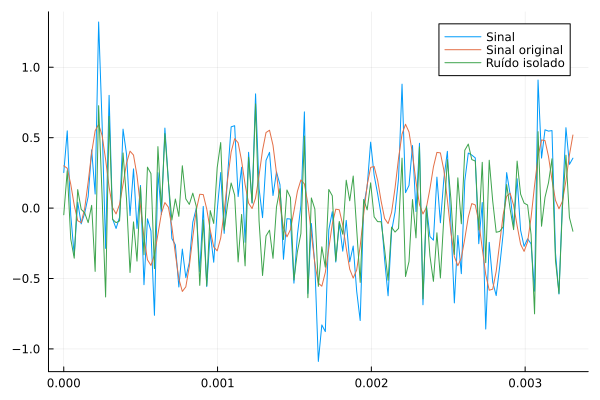

In [9]:
sinal_original = senoidal.(t, 1e3, 0.3) + cosseno.(t, 4.5e3, 0.3)
sinal_ruidoso = sinal_original + ruido.(t, 0.3) # Sinal recebido após passar por canal ruidoso

ruido_isolado = sinal_ruidoso - sinal_original

wavplay(sinal_ruidoso * 0.5, fs)

funcoes = [sinal_ruidoso sinal_original ruido_isolado]
legendas = ["Sinal" "Sinal original" "Ruído isolado"]

funcoes_plot = funcoes[1:janela_amostral,:]

dir_tom = "graficos/tom/"
mkpath(dir_tom)

savefig(plot(t_plot, funcoes_plot[:, 1], label="Sinal ruidoso", lc=:green, ylims=(-1, 1)), string(dir_tom, "ruidoso.png"))
savefig(plot(t_plot, funcoes_plot[:, 2], label="Sinal original", lc=:blue, ylims=(-1, 1)), string(dir_tom, "original.png"))
savefig(plot(t_plot, funcoes_plot[:, 3], label="Ruído isolado", lc=:red, ylims=(-1, 1)), string(dir_tom, "ruido.png"))

plot(t_plot, funcoes_plot, label=legendas)

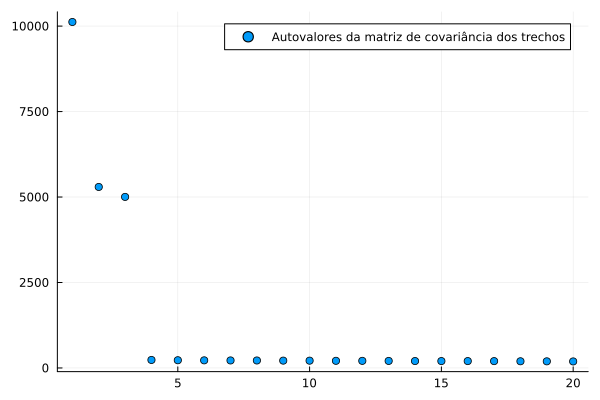

In [10]:
fig = mostra_autovalores_covariancia(sinal_ruidoso)
savefig(fig, string(dir_tom, "autovalores.png"))
fig

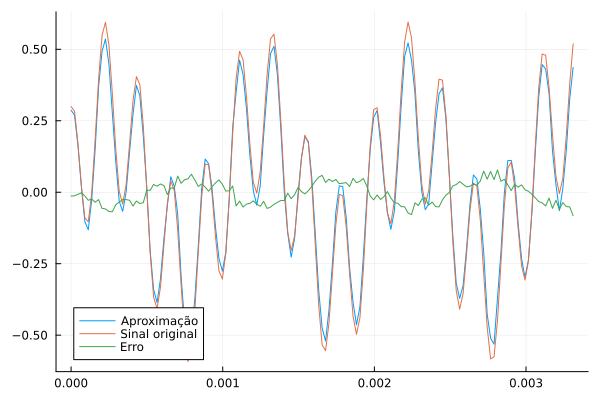

In [11]:
aprox = aproxima_sinal(sinal_ruidoso, 3)
erro = aprox - sinal_original

wavplay(aprox * 0.5, fs)

funcoes = [aprox sinal_original erro]
funcoes_plot = funcoes[1:janela_amostral,:]
legendas = ["Aproximação" "Sinal original" "Erro"]

savefig(plot(t_plot, funcoes_plot[:, 1], label="Aproximação obtida", lc=:green, ylims=(-1, 1)), string(dir_tom, "aprox_obtida.png"))
savefig(plot(t_plot, funcoes_plot[:, 3], label="Erro isolado", lc=:red, ylims=(-1, 1)), string(dir_tom, "erro_isolado_aprox.png"))

plot(t_plot, funcoes_plot, label=legendas)

### Exemplo 3: Onda triangular

In [12]:
function triangular(x, freq, intensidade)
    (2 * abs(x * freq - floor(x*freq + 1/2))) * intensidade
end

triangular (generic function with 1 method)

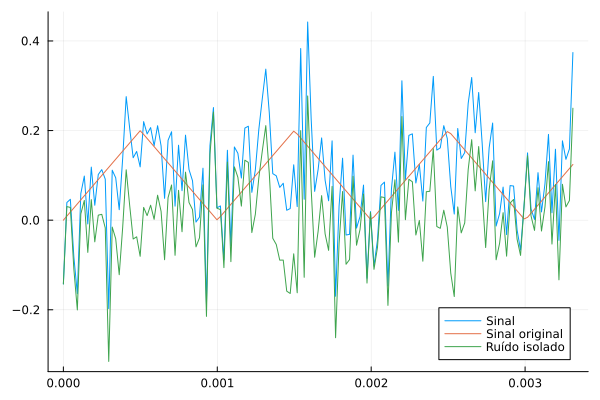

In [13]:
sinal_original = triangular.(t, 1e3, 0.2)
sinal_ruidoso = sinal_original + ruido.(t, 0.1)

ruido_isolado = sinal_ruidoso - sinal_original

wavplay(sinal_ruidoso, fs)


funcoes = [sinal_ruidoso sinal_original ruido_isolado]
funcoes_plot = funcoes[1:janela_amostral,:]
legendas = ["Sinal" "Sinal original" "Ruído isolado"]

dir_trig = "graficos/triangular/"
mkpath(dir_trig)
savefig(plot(t_plot, funcoes_plot[:, 1], label="Sinal ruidoso", lc=:blue, ylims=(-0.4, 0.4)), string(dir_trig, "ruidoso.png"))

plot(t_plot, funcoes_plot, label=legendas)

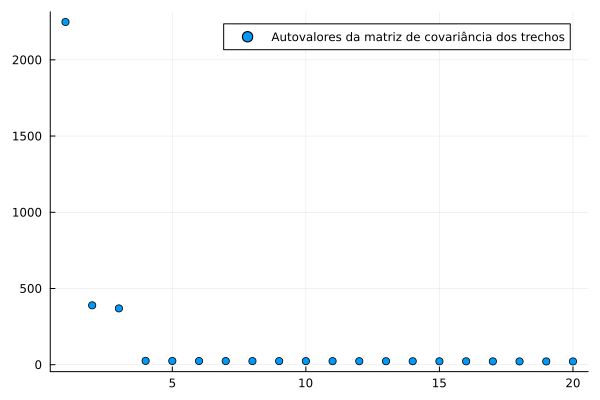

In [14]:
mostra_autovalores_covariancia(sinal_ruidoso)

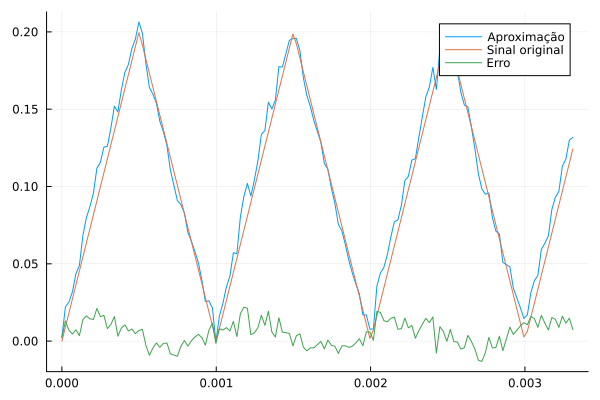

In [15]:
aprox = aproxima_sinal(sinal_ruidoso, 3)
erro = aprox - sinal_original

wavplay(aprox, fs)

funcoes = [aprox sinal_original erro]
funcoes_plot = funcoes[1:janela_amostral,:]
legendas = ["Aproximação" "Sinal original" "Erro"]

savefig(plot(t_plot, [funcoes_plot[:, 1] funcoes_plot[:, 3]], label=["Aproximação obtida" "Erro"], lc=["green" "red"], ylims=(-0.4, 0.4)), string(dir_trig, "aprox_erro.png"))

plot(t_plot, funcoes_plot, label=legendas)

### Exemplo 4: Onda quadrada

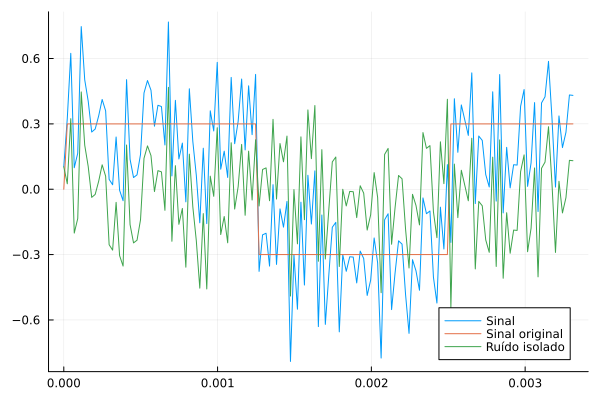

In [16]:
sinal_original = sign.(senoidal.(t, 0.4e3, 1)) * 0.3
sinal_ruidoso = sinal_original + ruido.(t, 0.2)

ruido_isolado = sinal_ruidoso - sinal_original

wavplay(sinal_ruidoso, fs)


funcoes = [sinal_ruidoso sinal_original ruido_isolado]
funcoes_plot = funcoes[1:janela_amostral,:]
legendas = ["Sinal" "Sinal original" "Ruído isolado"]

dir_quad = "graficos/quadrada/"
mkpath(dir_quad)

savefig(plot(t_plot, funcoes_plot[:, 1], label="Sinal ruidoso", lc=:blue, ylims=(-0.5, 0.5)), string(dir_quad, "ruidoso.png"))

plot(t_plot, funcoes_plot, label=legendas)

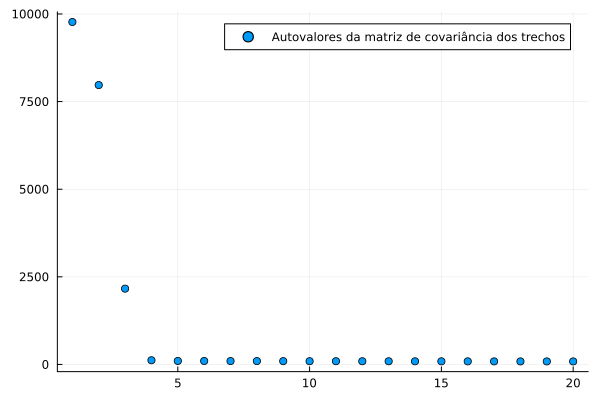

In [17]:
mostra_autovalores_covariancia(sinal_ruidoso)

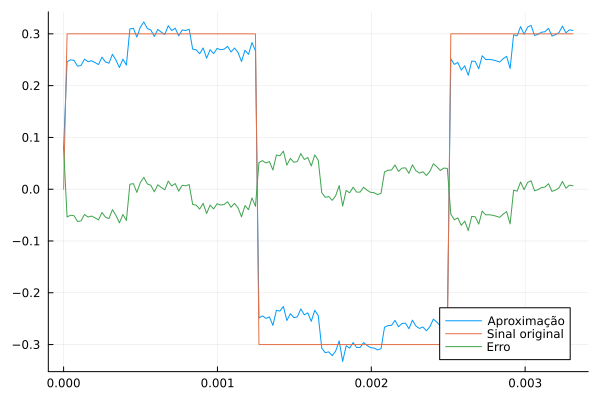

In [18]:
aprox = aproxima_sinal(sinal_ruidoso, 3)
erro = aprox - sinal_original

wavplay(aprox, fs)

funcoes = [aprox sinal_original erro]
funcoes_plot = funcoes[1:janela_amostral,:]
legendas = ["Aproximação" "Sinal original" "Erro"]

savefig(plot(t_plot, [funcoes_plot[:, 1] funcoes_plot[:, 3]], label=["Aproximação obtida" "Erro"], lc=["green" "red"], ylims=(-0.5, 0.5)), string(dir_quad, "aprox_erro.png"))

plot(t[1:janela_amostral], funcoes_plot, label=legendas)

### Exemplo 5: Sawtooth wave

In [19]:
function sawtooth(t, freq, intensidade)
    return 2 * (t * freq - floor(1/2 + t * freq)) * intensidade
end

sawtooth (generic function with 1 method)

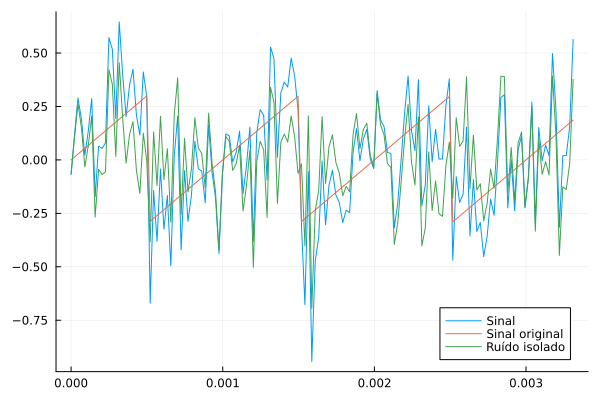

In [20]:
sinal_original = sawtooth.(t, 1e3, 0.3)
sinal_ruidoso = sinal_original + ruido.(t, 0.2)

ruido_isolado = sinal_ruidoso - sinal_original

wavplay(sinal_ruidoso, fs)


funcoes = [sinal_ruidoso sinal_original ruido_isolado]
funcoes_plot = funcoes[1:janela_amostral,:]
legendas = ["Sinal" "Sinal original" "Ruído isolado"]

dir_sawtooth = "graficos/sawtooh/"
mkpath(dir_sawtooth)

savefig(plot(t_plot, funcoes_plot[:, 1], label="Sinal ruidoso", lc=:blue, ylims=(-0.5, 0.5)), string(dir_sawtooth, "ruidoso.png"))

plot(t[1:janela_amostral], funcoes_plot, label=legendas)

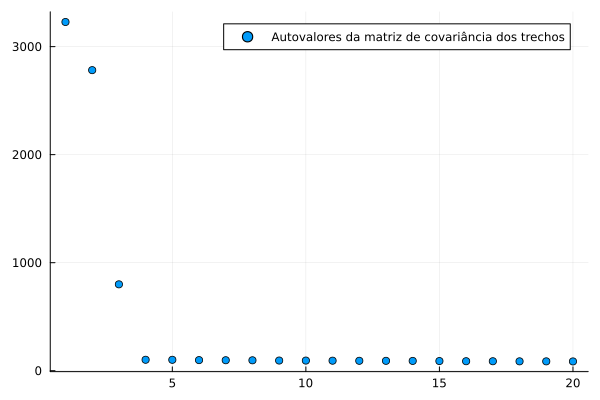

In [21]:
mostra_autovalores_covariancia(sinal_ruidoso)

In [22]:
aprox = aproxima_sinal(sinal_ruidoso, 3)
erro = aprox - sinal_original

wavplay(aprox, fs)

funcoes = [aprox sinal_original erro]
funcoes_plot = funcoes[1:janela_amostral,:]
legendas = ["Aproximação" "Sinal original" "Erro"]

savefig(plot(t_plot, [funcoes_plot[:, 1] funcoes_plot[:, 3]], label=["Aproximação obtida" "Erro"], lc=["green" "red"], ylims=(-0.4, 0.4)), string(dir_sawtooth, "aprox_erro.png"))

plot(t[1:janela_amostral], funcoes_plot, label=legendas)

LoadError: SystemError: opening file "/home/leaaaaaao/Documentos/Matérias/COCADA/Trab final/graficos/sawtooh/aprox_erro.png": Arquivo ou diretório inexistente

### Sinais muito ruidosos

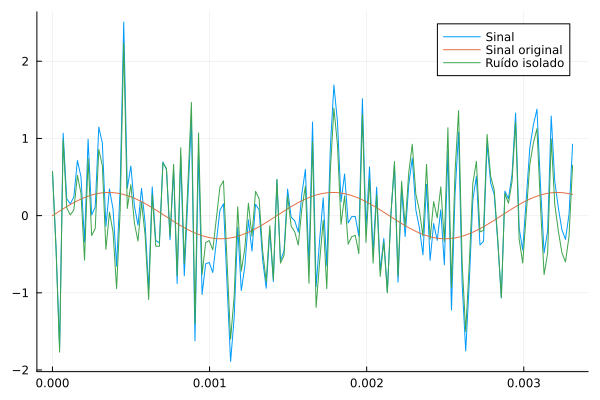

In [23]:
sinal_original = senoidal.(t, 0.7e3, 0.3) # Sinal enviado originalmente
sinal_ruidoso = sinal_original + ruido.(t, 0.6) # Sinal recebido após passar por canal ruidoso

ruido_isolado = sinal_ruidoso - sinal_original

wavplay(sinal_ruidoso, fs)

funcoes = [sinal_ruidoso sinal_original ruido_isolado]
legendas = ["Sinal" "Sinal original" "Ruído isolado"]

dir_s2 = "graficos/senoidal_teste_2/"
t_plot = t[1:janela_amostral]
funcoes_plot = funcoes[1:janela_amostral,:]

mkpath(dir_s2)
savefig(plot(t_plot, funcoes_plot[:, 2], label="Sinal original", lc=:blue, ylims=(-1, 1)), string(dir_s2, "original.png"))
savefig(plot(t_plot, funcoes_plot[:, 1], label="Sinal ruidoso", lc=:green, ylims=(-2, 2)), string(dir_s2, "ruidoso.png"))

plot(t_plot, funcoes_plot, label=legendas)

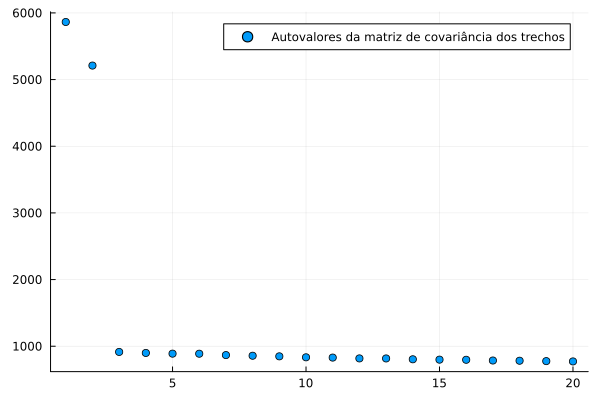

In [24]:
mostra_autovalores_covariancia(sinal_ruidoso)

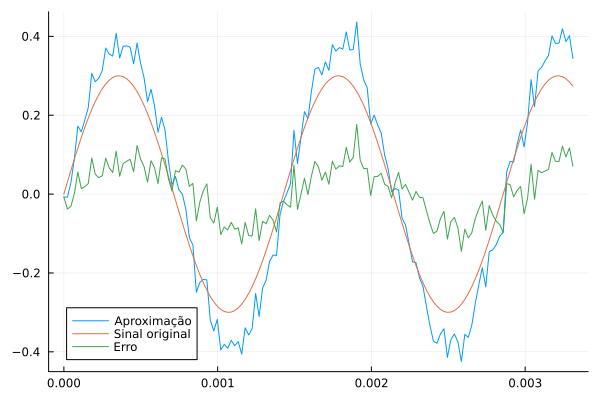

In [25]:
aprox = aproxima_sinal(sinal_ruidoso, 2)
erro = aprox - sinal_original

wavplay(aprox, fs)

funcoes = [aprox sinal_original erro]
funcoes_plot = funcoes[1:janela_amostral,:]
legendas = ["Aproximação" "Sinal original" "Erro"]

savefig(plot(t_plot, [funcoes_plot[:, 1] funcoes_plot[:, 3]], label=["Aproximação obtida" "Erro"], lc=["green" "red"], ylims=(-1, 1)), string(dir_s2, "aprox_erro.png"))

plot(t_plot, funcoes_plot, label=legendas)